In [44]:
import kaolin
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from io import BytesIO
from PIL import Image
import sdfpred_utils.sdfpred_utils as su
import sdfpred_utils.sdf_MLP as mlp
import sdfpred_utils.sdf_functions as sdf
import sdfpred_utils.loss_functions as lf
import trimesh
from scipy.spatial import Delaunay, Voronoi


#cuda devices
device = torch.device("cuda:0")
print("Using device: ", torch.cuda.get_device_name(device))

#default tensor types
torch.set_default_tensor_type(torch.cuda.DoubleTensor)

multires = 2
input_dims = 3
lr_sites = 0.03
lr_model = 0.0003
iterations = 5000
save_every = 100
max_iter = 100
#learning_rate = 0.03
destination = "./images/autograd/3D/"


Using device:  NVIDIA GeForce RTX 3090


In [45]:
sites = su.createCVTgrid(num_centroids=256, dimensionality=3)

torch.Size([256, 3]) torch.float64


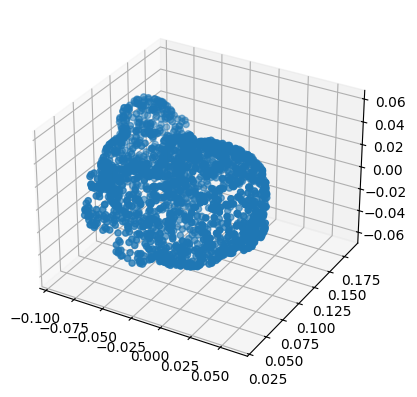

In [46]:
bunny = trimesh.load("Resources/stanford-bunny.obj")
#smple target_points from the bunny
target_points = bunny.sample(2048)

#plot the bunny
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(target_points[:,0], target_points[:,1], target_points[:,2])
plt.show()



In [47]:
import matplotlib
import os

model = mlp.Decoder(multires=multires, input_dims=input_dims).to(device)
model_path = 'models_resources/pretrained_sphere_small.pth'
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print('loaded model')
else:
    print("no model found, pretraining")
    model.pre_train_sphere(3000)
    torch.save(model.state_dict(),model_path)

loaded model


In [54]:
#Todo this should also work in 2d, might want to adjust the simplex iteration
def get_delaunay_neighbors_list_3d(sites):
    # Detach and convert to NumPy for Delaunay triangulation
    points_np = sites.detach().cpu().numpy()
    
    # Compute the Delaunay tessellation
    tri = Delaunay(points_np)

    # Find the neighbors of each point
    neighbors = {i: set() for i in range(len(points_np))}
    for simplex in tri.simplices:  # Each simplex is a tetrahedron (4 points)
        for i in range(4):  # Iterate over each of the 4 vertices
            for j in range(i + 1, 4):  # Connect each pair of points
                neighbors[simplex[i]].add(simplex[j])
                neighbors[simplex[j]].add(simplex[i])

    # Convert sets to lists for easier use
    neighbors = {key: list(value) for key, value in neighbors.items()}
    return neighbors

def compute_vertices_index_3d(neighbors):
    vertices_index_to_compute = []
    
    for site, adjacents in neighbors.items():
        for i in adjacents:
            for n in adjacents:
                if n != site and n != i and n in neighbors[i]:  # Ensuring a triangle exists
                    for m in adjacents:
                        if m != site and m != i and m != n and m in neighbors[i] and m in neighbors[n]:
                            # We now have 4 mutually connected points forming a tetrahedron
                            vertices_index_to_compute.append([i, site, n, m])
    
    # Deduplicate tetrahedra (avoid different orderings of the same set)
    seen_tetrahedra = set()
    filtered_tetrahedra = []

    for tetrahedron in vertices_index_to_compute:
        canonical_tetrahedron = tuple(sorted(tetrahedron, key=str))  # Sort for uniqueness
        if canonical_tetrahedron not in seen_tetrahedra:
            seen_tetrahedra.add(canonical_tetrahedron)
            filtered_tetrahedra.append(tetrahedron)
    
    return filtered_tetrahedra

def compute_zero_crossing_vertices_3d(sites, model):
    """
    Computes the indices of the sites composing vertices where neighboring sites have opposite or zero SDF values.

    Args:
        sites (torch.Tensor): (N, D) tensor of site positions.
        model (callable): Function or neural network that computes SDF values.

    Returns:
        zero_crossing_vertices_index (list of triplets): List of sites indices (si, sj, sk) where atleast 2 sites have opposing SDF signs.
    """
    # Compute Delaunay neighbors
    neighbors = get_delaunay_neighbors_list_3d(sites)

    # Compute SDF values for all sites
    sdf_values = model(sites)  # Assuming model outputs (N, 1) or (N,) tensor

    # Find pairs of neighbors with opposing SDF values
    zero_crossing_pairs = set()
    for i, adjacents in neighbors.items():
        for j in adjacents:
            if i < j:  # Avoid duplicates
                sdf_i, sdf_j = sdf_values[i].item(), sdf_values[j].item()
                if sdf_i * sdf_j <= 0:  # Opposing signs or one is zero
                    zero_crossing_pairs.add((i, j))

    # Compute tetrahedra (quadruplets) and filter only those involving zero-crossing pairs
    all_tetrahedra = compute_vertices_index_3d(neighbors)  # Now returns quadruplets
    zero_crossing_vertices_index = []
    
    for tetrahedron in all_tetrahedra:
        tetrahedron_pairs = {
            (tetrahedron[0], tetrahedron[1]), (tetrahedron[0], tetrahedron[2]), (tetrahedron[0], tetrahedron[3]),
            (tetrahedron[1], tetrahedron[2]), (tetrahedron[1], tetrahedron[3]), (tetrahedron[2], tetrahedron[3])
        }
        if any(pair in zero_crossing_pairs for pair in tetrahedron_pairs):
            zero_crossing_vertices_index.append(tetrahedron)

    return zero_crossing_vertices_index, zero_crossing_pairs


# def compute_vertex(s_i, s_j, s_k):
#     # Unpack coordinates for each site
#     x_i, y_i = s_i[0], s_i[1]
#     x_j, y_j = s_j[0], s_j[1]
#     x_k, y_k = s_k[0], s_k[1]
    
#     # Calculate numerator and  for x coordinate
#     n_x = (
#         x_i**2 * (y_j - y_k)
#         - x_j**2 * (y_i - y_k)
#         + (x_k**2 + (y_i - y_k) * (y_j - y_k)) * (y_i - y_j)
#     )

#     # Calculate numerator for y coordinate
#     n_y = -(
#         x_i**2 * (x_j - x_k)
#         - x_i * (x_j**2 - x_k**2 + y_j**2 - y_k**2)
#         + x_j**2 * x_k
#         - x_j * (x_k**2 - y_i**2 + y_k**2)
#         - x_k * (y_i**2 - y_j**2)
#     )
    
#     # Calculate denominator 
#     d = 2 * (x_i * (y_j - y_k) - x_j * (y_i - y_k) + x_k * (y_i - y_j))
    
#     # Calculate x and y coordinates
#     x = n_x / d
#     y = n_y / d

#     # Return x, y as a tensor to maintain the computational graph
#     return torch.stack([x, y])

def compute_vertex_3d(s_i, s_j, s_k, s_l):
    """
    Computes the circumcenter of a tetrahedron given four sites in 3D.

    Args:
        s_i, s_j, s_k, s_l (torch.Tensor): 3D coordinates of four sites (shape: (3,)).

    Returns:
        torch.Tensor: The circumcenter (x, y, z).
    """
    # Convert to coordinate form
    x_i, y_i, z_i = s_i
    x_j, y_j, z_j = s_j
    x_k, y_k, z_k = s_k
    x_l, y_l, z_l = s_l

    # Compute squared norms
    s_i2 = x_i**2 + y_i**2 + z_i**2
    s_j2 = x_j**2 + y_j**2 + z_j**2
    s_k2 = x_k**2 + y_k**2 + z_k**2
    s_l2 = x_l**2 + y_l**2 + z_l**2

    # Construct matrix system
    A = torch.tensor([
        [x_i, y_i, z_i, 1],
        [x_j, y_j, z_j, 1],
        [x_k, y_k, z_k, 1],
        [x_l, y_l, z_l, 1]
    ], dtype=torch.float32)

    Dx = torch.tensor([
        [s_i2, y_i, z_i, 1],
        [s_j2, y_j, z_j, 1],
        [s_k2, y_k, z_k, 1],
        [s_l2, y_l, z_l, 1]
    ], dtype=torch.float32)

    Dy = torch.tensor([
        [x_i, s_i2, z_i, 1],
        [x_j, s_j2, z_j, 1],
        [x_k, s_k2, z_k, 1],
        [x_l, s_l2, z_l, 1]
    ], dtype=torch.float32)

    Dz = torch.tensor([
        [x_i, y_i, s_i2, 1],
        [x_j, y_j, s_j2, 1],
        [x_k, y_k, s_k2, 1],
        [x_l, y_l, s_l2, 1]
    ], dtype=torch.float32)

    # Compute determinants
    detA = torch.det(A)
    detDx = torch.det(Dx)
    detDy = -torch.det(Dy)  # Negative due to orientation
    detDz = torch.det(Dz)

    # Compute circumcenter coordinates
    x = 0.5 * (detDx / detA)
    y = 0.5 * (detDy / detA)
    z = 0.5 * (detDz / detA)

    return torch.stack([x, y, z])

# def compute_all_vertices(sites, vertices_to_compute):
#     # Initialize an empty tensor for storing vertices
#     vertices = []
    
#     for triplet in vertices_to_compute:
#         si = sites[triplet[0]]
#         sj = sites[triplet[1]]
#         sk = sites[triplet[2]]
        
#         # Compute vertex for the triplet (si, sj, sk)
#         v = compute_vertex_3d(si, sj, sk)
        
#         # Append to the list
#         vertices.append(v)
    
#     # Stack the list of vertices into a single tensor for easier gradient tracking
#     vertices = torch.stack(vertices)
#     return vertices

def compute_all_vertices_3d(sites, vertices_to_compute):
    """
    Computes all Voronoi vertices for a given set of tetrahedra.

    Args:
        sites (torch.Tensor): (N, 3) tensor of site positions.
        vertices_to_compute (list of quadruplets): List of indices forming tetrahedra.

    Returns:
        torch.Tensor: Computed Voronoi vertices.
    """
    vertices = []
    
    for quadruplet in vertices_to_compute:
        si = sites[quadruplet[0]]
        sj = sites[quadruplet[1]]
        sk = sites[quadruplet[2]]
        sl = sites[quadruplet[3]]

        # Compute circumcenter for the tetrahedron
        v = compute_vertex_3d(si, sj, sk, sl)
        vertices.append(v)

    # Stack all vertices into a single tensor
    vertices = torch.stack(vertices)
    return vertices

#Todo its the same in 3d if we only want a point. Do we want the plane ?
def compute_all_bisectors_3d(sites, bisectors_to_compute):
    # Initialize an empty tensor for storing bisectors
    bisectors = []
    
    for pairs in bisectors_to_compute:
        si = sites[pairs[0]]
        sj = sites[pairs[1]]
        b = (si + sj) / 2
        bisectors.append(b)

    # Stack the list of bisectors into a single tensor for easier gradient tracking
    bisectors = torch.stack(bisectors)
    return bisectors

#Todo see above
# def compute_all_bisector_planes_3d(sites, bisectors_to_compute):
#     """
#     Computes bisector planes for given site pairs in 3D.

#     Args:
#         sites (torch.Tensor): (N, 3) tensor of site positions.
#         bisectors_to_compute (list of pairs): List of index pairs (i, j).

#     Returns:
#         torch.Tensor: Plane normals (N, 3) and midpoints (N, 3).
#     """
#     midpoints = []
#     normals = []
    
#     for pair in bisectors_to_compute:
#         si = sites[pair[0]]
#         sj = sites[pair[1]]
        
#         midpoint = (si + sj) / 2  # Midpoint
#         normal = sj - si  # Normal direction
        
#         midpoints.append(midpoint)
#         normals.append(normal)

#     # Stack into tensors
#     midpoints = torch.stack(midpoints)
#     normals = torch.stack(normals)
    
#     return normals, midpoints





In [49]:
cvt_loss_values = []
min_distance_loss_values = []
edge_smoothing_loss_values = []
chamfer_distance_loss_values = []
eikonal_loss_values = []
domain_restriction_loss_values = []
zero_true_points_loss_values = []
loss_values = []

def autograd(sites, model, max_iter=100, stop_train_threshold=1e-6, upsampling=0, lambda_weights = [0.1,1.0,0.1,0.1,1.0,1.0,0.1]):
    optimizer = torch.optim.Adam([
    {'params': [p for _, p in model.named_parameters()], 'lr': lr_model},
    {'params': [sites], 'lr': lr_sites}
], betas=(0.5, 0.999))

    prev_loss = float("inf")
    best_loss = float("inf")
    upsampled = 0.0
    epoch = 0
    lambda_cvt = lambda_weights[0]
    lambda_sdf = lambda_weights[1]
    lambda_min_distance = lambda_weights[2]
    lambda_laplace = lambda_weights[3]
    lamda_chamfer = lambda_weights[4]
    lamda_eikonal = lambda_weights[5]
    lambda_domain_restriction = lambda_weights[6]
    lambda_true_points = lambda_weights[7]
    
    best_sites = sites.clone()
    best_sites.best_loss = best_loss
    
    while epoch <= max_iter:
        optimizer.zero_grad()
        
        vertices_to_compute, bisectors_to_compute = compute_zero_crossing_vertices_3d(sites, model)
        vertices = compute_all_vertices_3d(sites, vertices_to_compute)
        bisectors = compute_all_bisectors_3d(sites, bisectors_to_compute)
    
        #combine vertices and bisectors to one tensor for chamfer
        points = torch.cat((vertices, bisectors), 0)

        # Compute losses       
        cvt_loss = lf.compute_cvt_loss(sites)
        #min_distance_loss = min_distance_regularization_for_op_sites(edges,sites)
        min_distance_loss = lf.sdf_weighted_min_distance_loss(model, sites)
        #edge_smoothing_loss = compute_edge_smoothing_loss(edges, sites, model)
        chamfer_loss = lf.chamfer_distance(true_points, points)
        eikonal_loss = lf.eikonal(model)
        domain_restriction_loss = lf.domain_restriction(true_points, model)
        
        sdf_values_true_points = model(true_points)[:,0]
        zero_true_points_loss_L2 = torch.mean(sdf_values_true_points**2)
        zero_true_points_loss_L1 = torch.mean(torch.abs(model(true_points)[:, 0]))
        lambda_1, lambda_2 = 0 , 0.99  # Adjust weights as needed
        zero_true_points_loss = lambda_1 * zero_true_points_loss_L1 + lambda_2 * zero_true_points_loss_L2

               
        # Track raw losses (unweighted)
        cvt_loss_values.append(cvt_loss.item())
        min_distance_loss_values.append(min_distance_loss.item())
        #edge_smoothing_loss_values.append(edge_smoothing_loss.item())
        chamfer_distance_loss_values.append(chamfer_loss.item())
        eikonal_loss_values.append(eikonal_loss.item())
        domain_restriction_loss_values.append(domain_restriction_loss.item())
        zero_true_points_loss_values.append(zero_true_points_loss.item())
  
        loss = (
            lambda_cvt * cvt_loss +
            lambda_min_distance * min_distance_loss + 
            #lambda_laplace * edge_smoothing_loss +
            lamda_chamfer * chamfer_loss +
            lamda_eikonal * eikonal_loss +
            lambda_domain_restriction * domain_restriction_loss +
            lambda_true_points * zero_true_points_loss
        )
        loss_values.append(loss.item())
        print(f"Epoch {epoch}: loss = {loss.item()}")
                
        loss.backward()
        optimizer.step()
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_epoch = epoch
            best_sites = sites.clone()
            best_sites.best_loss = best_loss
            if upsampled > 0:
                print(f"UPSAMPLED {upsampled} Best Epoch {best_epoch}: Best loss = {best_loss}")
                #return best_sites
        
        if abs(prev_loss - loss.item()) < stop_train_threshold:
            print(f"Converged at epoch {epoch} with loss {loss.item()}")
            #break
        
        prev_loss = loss.item() 
        
        if epoch>100 and (epoch // 100) == upsampled+1 and loss.item() < 0.5 and upsampled < upsampling:
            print("sites length: ",len(sites))
            
            new_sites = su.upsampling_inside(best_sites, model)
            #new_sites = su.adaptive_density_upsampling(best_sites, model)
            print(new_sites)
            sites = su.add_upsampled_sites(best_sites, new_sites)
            sites = sites.detach().requires_grad_(True)
            print("upsampled sites length: ",len(sites))
            
            best_sites = sites.clone()
            best_sites.best_loss = best_loss
            
            optimizer = torch.optim.Adam([{'params': [p for _, p in model.named_parameters()], 'lr': lr_model},
                                          {'params': [sites], 'lr': lr_sites}])
            upsampled += 1.0
          
        if epoch % (max_iter/10) == 0:
            print(f"Epoch {epoch}: loss = {loss.item()}")
            print(f"Best Epoch {best_epoch}: Best loss = {best_loss}")
        
        epoch += 1           
        
    return best_sites

In [50]:
# lambda_weights = [0.2,0,0.1,0,1.0,0.1,0,2]

# lambda_cvt = lambda_weights[0]
# lambda_sdf = lambda_weights[1]
# lambda_min_distance = lambda_weights[2]
# lambda_laplace = lambda_weights[3]
# lamda_chamfer = lambda_weights[4]
# lambda_eikonal = lambda_weights[5]
# lambda_domain_restriction = lambda_weights[6]
# lambda_true_points = lambda_weights[7]

# max_iter = 500

# site_file_path = f'{destination}{max_iter}3d_sites_chamfer{lamda_chamfer}.npy'
# #check if optimized sites file exists
# if os.path.exists(site_file_path):
#     #import sites
#     print("Importing sites")
#     sites = np.load(site_file_path)
#     sites = torch.from_numpy(sites).to(device).requires_grad_(True)    
# else:
#     sites = autograd(sites, model, max_iter=max_iter, upsampling=2, lambda_weights=lambda_weights)
#     sites_np = sites.detach().cpu().numpy()
#     np.save(site_file_path, sites_np)